# How to detect face landmarks?

In [1]:
import sys
sys.path.append('../')
from src.dataset import read_folder
import cv2
import numpy as np

In [2]:
from src.landmarks import Landmarks

In [3]:
import matplotlib.pyplot as plt
from src.visualization import plot_landmarks_color
from src.visualization import plot_img

In [4]:
PATH = '../LaPa/examples'

In [5]:
images = read_folder(PATH, n = None, landmarks= 'landmarks', RGB = True)

# Dlib

In [6]:
import dlib
from imutils import face_utils

All needed .dat files you can find under the link: https://github.com/davisking/dlib-models or : http://dlib.net/files/, please read it! You can find there a lot of great informations/tutorials/explanations. Obviously i highly recommend you to check more option in offical webside: http://dlib.net/python/index.html.

In this tututorial "shape_predictor_68_face_landmarks.dat" is used because it is designed for use with dlib's HOG face detector, and I wanted show that there are methods which do not need networks :)
This file is not in repo, because I wanted encourage you to download and browse links in person. Without this file you should get RuntimeError: "Unable to open shape_predictor_68_face_landmarks.dat".

In [7]:
DETECTOR = dlib.get_frontal_face_detector() #the default face detector
PREDICTOR = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [8]:
def face_detec_plot(img, rects):
    plt.imshow(img)
    plt.plot([rects[0].bottom(), rects[0].bottom(), rects[0].top(), rects[0].top(), rects[0].bottom()], 
             [rects[0].right(),rects[0].left(), rects[0].left(), rects[0].right(), rects[0].right()])
    plt.axis('off')

In [9]:
def detect_face(gray, img, DETECTOR, plot = True):
    rects = DETECTOR(gray, 1)
    if plot:
        if len(rects) == 0: 
            raise ValueError("Ops! Face has not been detected", rects)
        else:
            face_detec_plot(img, rects)
    return rects

In [10]:
example_img = list(images.keys())[6]
img_RGB = images[example_img]['img']
gray = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)

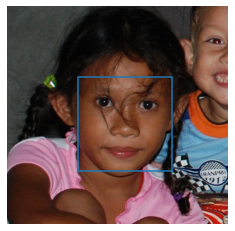

In [11]:
rects = detect_face(gray, img_RGB, DETECTOR)

In [12]:
def face_predict_landmarks(gray, rect, PREDICTOR):
    """predict face landmarks using PREDICTOR dlib's object,
    rects is the bounding box to begin the shape prediction inside. """
    landmarks = PREDICTOR(gray, rect) # http://dlib.net/python/index.html#dlib.shape_predictor (__call__ method)
    landmarks = face_utils.shape_to_np(landmarks)
    
    # now let's return object Landmarks, Class Landmarks is defined in src/landmarks.py file, 
    # more about it you can find in notebook: /MeetDataset/meetDataset.ipynb
    return Landmarks(landmarks) 

In [13]:
rects

rectangles[[(167, 167) (390, 390)]]

In [14]:
landmarks = face_predict_landmarks(gray, rects[0], PREDICTOR)

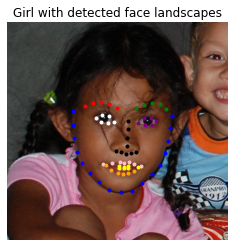

In [15]:
plot_img(img_RGB)
plot_landmarks_color(landmarks)
plt.title('Girl with detected face landscapes')
plt.show()

## what if (...)
- there is mostly only half face visible? -- well, the result should not be surprised, especially since we used "get_frontal_face_detector" function :)  

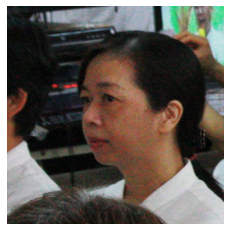

In [16]:
example_img = list(images.keys())[1]
img_RGB = images[example_img]['img']
gray = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
plot_img(img_RGB)

In [17]:
# We should get ValueError "Face has not been detected" 
rects = detect_face(gray, img_RGB, DETECTOR)

ValueError: ('Ops! Face has not been detected', rectangles[])

BUT! Landmark prediction methods are statistical methods, which means that they should work almost always (of course not necessarily well). The problem is that we have to find "interesting" rectangle without DETECTOR.

In [18]:
#Let's try find "interesting" rectangle writing just more or less random numbers
rectangle1 = dlib.rectangle(0, 0, *img_RGB.shape[:2])
rectangle2 = dlib.rectangle(*(np.array(img_RGB.shape[:2])/3).astype(int), *(np.array(img_RGB.shape[:2])*2/3).astype(int))
rectangle3 = dlib.rectangle(152,152,400,400)

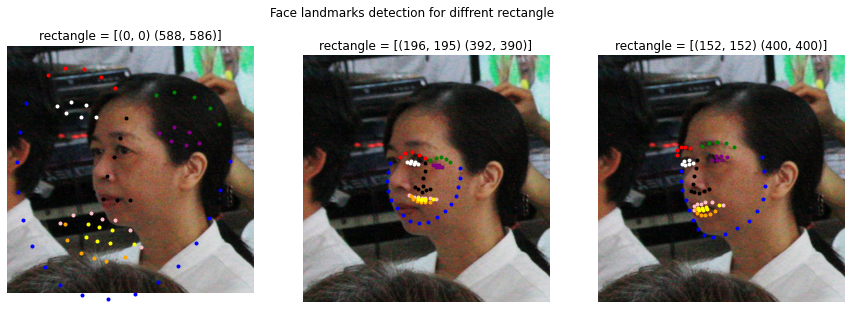

In [19]:
f, ax = plt.subplots(1,3, figsize=(15,5))

plot_img(img_RGB, ax = ax[0])
landmarks = face_predict_landmarks(gray, rectangle1, PREDICTOR)
plot_landmarks_color(landmarks, ax = ax[0])
ax[0].set_title(f'rectangle = {rectangle1}')

plot_img(img_RGB, ax = ax[1])
landmarks = face_predict_landmarks(gray, rectangle2, PREDICTOR)
plot_landmarks_color(landmarks, ax = ax[1])
ax[1].set_title(f'rectangle = {rectangle2}')

plot_img(img_RGB, ax = ax[2])
landmarks = face_predict_landmarks(gray, rectangle3, PREDICTOR)
plot_landmarks_color(landmarks, ax = ax[2])
ax[2].set_title(f'rectangle = {rectangle3}')

f.suptitle('Face landmarks detection for diffrent rectangle')
plt.show()

# MediaPipe

In [20]:
import mediapipe as mp

It is ready-to-use Python Solution, which basicly means that we used pretrained models

We can find faces on images if we want using: `MediaPipe Face Detection` https://google.github.io/mediapipe/solutions/face_detection#python-solution-api
but there is no need find intresing regions to face landmarks (which will be intresing for us). To find landmarks we will use: `MediaPipe Face Mesh` (https://google.github.io/mediapipe/solutions/face_mesh#face-landmark-model)

What I highly recommend you is .... check their github https://github.com/google/mediapipe! especially:
https://github.com/google/mediapipe/blob/master/mediapipe/python/solutions/face_mesh.py

In [21]:
# Create MediaPipe Face Mesh 's object to  processes an RGB image and returns the face landmarks on  each detected face.
faceMeshModel = mp.solutions.face_mesh.FaceMesh()

In [22]:
example_img = list(images.keys())[6]
img_RGB = images[example_img]['img']

In [23]:
results = faceMeshModel.process(img_RGB) 

Does it? YES! 

Do I have 3D landmarks? YES!

Of course let's check how `results` looks like:

In [24]:
results # results is object, it has a lot of uesefull methods, which can help us understanding i.a. faces' landmarks

mediapipe.python.solution_base.SolutionOutputs

to get landmarks coordinates we can call a results.multi_face_landmarks. Output is list of landmarks

In [25]:
results.multi_face_landmarks

[landmark {
   x: 0.5272213816642761
   y: 0.6497410535812378
   z: -0.0339466817677021
 }
 landmark {
   x: 0.5296008586883545
   y: 0.5878203511238098
   z: -0.09310737252235413
 }
 landmark {
   x: 0.5282211303710938
   y: 0.6036430597305298
   z: -0.0414915457367897
 }
 landmark {
   x: 0.5177339315414429
   y: 0.518726110458374
   z: -0.08229396492242813
 }
 landmark {
   x: 0.5308296084403992
   y: 0.5680592656135559
   z: -0.10276702046394348
 }
 landmark {
   x: 0.5321659445762634
   y: 0.5403268337249756
   z: -0.10050015151500702
 }
 landmark {
   x: 0.5354807376861572
   y: 0.46953877806663513
   z: -0.06549696624279022
 }
 landmark {
   x: 0.40182867646217346
   y: 0.4471780061721802
   z: -0.002237537642940879
 }
 landmark {
   x: 0.5384218692779541
   y: 0.4104496240615845
   z: -0.06327097117900848
 }
 landmark {
   x: 0.5404025316238403
   y: 0.3810264468193054
   z: -0.07315395027399063
 }
 landmark {
   x: 0.5451346635818481
   y: 0.2762090265750885
   z: -0.078469946

fully list of points (x,y,z) is under results.multi_face_landmarks[0].landmark[:]

In [26]:
# example of x,y,z
results.multi_face_landmarks[0].landmark[:][0]

x: 0.5272213816642761
y: 0.6497410535812378
z: -0.0339466817677021

MediaPipe Face Mesh gives us possibilites to create 3D mask based on 2D RGB image

In [27]:
results.multi_face_landmarks[0].landmark[:][0]

x: 0.5272213816642761
y: 0.6497410535812378
z: -0.0339466817677021

In [28]:
x = []
y = [] 
z = []
for landmark in results.multi_face_landmarks[0].landmark[:]:
    x.append(landmark.x)
    y.append(landmark.y)
    z.append(landmark.z)

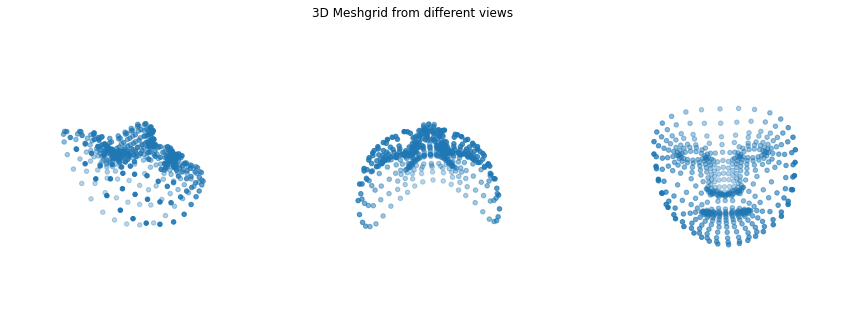

In [29]:
f, ax = plt.subplots(1,3, figsize=(15,5),subplot_kw=dict(projection='3d'))

ax[0].scatter3D(x, y, z);
ax[0].view_init(180, 10)
ax[0].axis('off')


ax[1].scatter3D(x, y, z);
ax[1].view_init(180, 90)
ax[1].axis('off')


ax[2].scatter3D(x, y, z);
ax[2].view_init(90, 90)
ax[2].axis('off')

f.suptitle('3D Meshgrid from different views')

plt.show()

Despite that this tutorial focous on 2D images, let's create 2D landmarks, and check how does it look like on original image:

In [30]:
def find_landmarks(img_RGB):
    results = faceMeshModel.process(img_RGB)
    x = []
    y = []
    image_rows, image_cols, _ = img_RGB.shape
    for landmark in results.multi_face_landmarks[0].landmark[:]:
        landmark_px = mp.solutions.drawing_utils._normalized_to_pixel_coordinates(landmark.x, landmark.y,
                                                       image_cols, image_rows)
        x.append(landmark_px[0])
        y.append(landmark_px[1])
    return x,y

In [31]:
x,y = find_landmarks(img_RGB)

In [32]:
landmarks = Landmarks(np.array([x,y]).T)

In [33]:
len(list(set(np.array(list(mp.solutions.face_mesh.FACEMESH_TESSELATION)).flatten())))

468

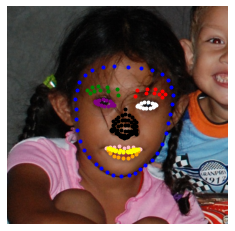

In [35]:
plot_landmarks_color(landmarks)
plot_img(img_RGB)

Rhe algorithm can also cope with the situation when the person in the photo is not facing the front. Hence, the result is 3D mask, the contour does not include the 2d face and creates the probable face contour in 3d (blue line). It works differently than for the dllib library.

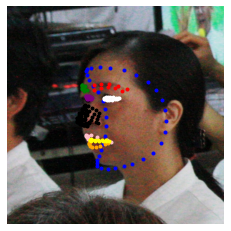

In [36]:
example_img = list(images.keys())[1]
img_RGB = images[example_img]['img']
x,y = find_landmarks(img_RGB)
landmarks = Landmarks(np.array([x,y]).T)
plot_landmarks_color(landmarks)
plot_img(img_RGB)